In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random
from thinker.actor_net import sample
from actpatchdrc import ActPatchDRCNet

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-01 09:52:35,902	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [3]:
class ProbingDataset(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> dict:
        return self.data[index]
    def get_feature_range(self, feature: str) -> tuple[int, int]:
        assert feature in self.data[0].keys(), f"Please enter a feature in dataset: {self.data[0].keys()}"
        min_feature_value, max_feature_value = self.data[0][feature], self.data[0][feature]
        for entry in self.data:
            if entry[feature] > max_feature_value:
                max_feature_value = entry[feature]
            elif entry[feature] < min_feature_value:
                min_feature_value = entry[feature]
        return (min_feature_value, max_feature_value)


class ProbingDatasetCleaned(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> tuple:
        return self.data[index]

In [28]:
val_data = torch.load("../probing/data/train_data_random.pt")

KeyboardInterrupt: 

In [ ]:
avg_layer2_cells_tick1 = torch.zeros_like(val_data[0]["hidden_states"][2,160:192,:,:])
for trans in val_data:
    avg_layer2_cells_tick1 += trans["hidden_states"][2,160:192,:,:]
avg_layer2_cells_tick1 = avg_layer2_cells_tick1 / len(val_data)

In [27]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_corrupt_0016-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
#actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state_corrupt = state

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


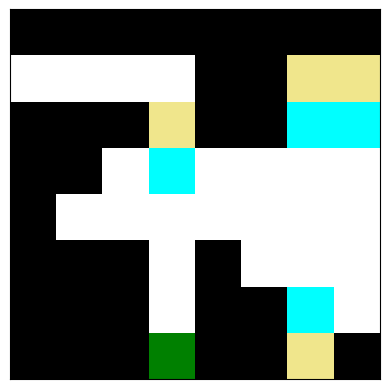

In [20]:
viz.plot_mini_sokoban(state_corrupt["real_states"][0])

In [21]:
_, _ = drc_net(env_out, rnn_state, greedy=True)
patch_activs = drc_net.hidden_state[:,1:,:,:,:].clone().detach()
#patch_activs[:,1,160:192,:,:] = avg_layer2_cells_tick1.clone().detach()

In [6]:
class ActPatchDRCNet:
    """
    Wrapper around DRCNet to patch in activations for different runs.
    """

    def __init__(self, drc_net, debug=False):
        self.drc_net = drc_net
        self.debug= debug

    def forward_normal(self, env_out, rnn_state):
        return self.drc_net(env_out, rnn_state)
    
    def forward_patch(self, env_out, rnn_state: tuple, greedy: bool = True, activ_type: Optional[str] = None, patch_dict: Optional[dict] = None, activ_ticks: Optional[list] = None, activs: Optional[torch.tensor] = None):
        """Run forward pass of wrapped DRCNet whilst patching in activations from activs

        Args:
            env_out (EnvOut): EnvOut object representing current state of environment
            rnn_state (tuple): current state of ConvLSTM - 2 tensors for each layer (e.g. h_t and c_t)
            greedy (bool, optional): whether to sample actions greedily. Defaults to True.
            activ_type (Optional[str], optional): an optional string that determines where to patching activations into - must be 'xenc', 'cell', 'hidden'- that is set to None if no patching is to occur. Defaults to None.
            patch_dict (Optional[dict], optional): a dictionary containing the channels to patch for the active_Type (hidden, cell, xenc) each layer e.g. if activ_type="hidden", to patch the first two channels of the hidden state for the first two layers {0: [0,1,] 1: [0,1]} . Defaults to None.
            activ_ticks (Optional[list], optional): list of ticks to patch over - if patching, must not be None. Defaults to None.
            activs (Optional[torch.tensor], optional): tensor of activations to patch in. Defaults to None.

        Returns:
            tuple: a tuple of (selected_action, action_probs, action_logits, updated_rnn_state)
        """
        
        activ_layers = list(patch_dict.keys())

        done = env_out.done
        T = done.shape[0]
        B = activs.shape[0]
        x = self.drc_net.normalize(env_out.real_states.float())
        x = torch.cat([x]*B, dim=0)
        x = torch.flatten(x, 0, 1)
        x_enc = self.drc_net.encoder(x)
        core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
        assert len(core_input.shape) == 5
        core_output_list = []
        reset = torch.cat([done]*B, dim=1).float()
        if self.drc_net.record_state: 
            self.drc_net.core.hidden_state = []
            self.drc_net.core.hidden_state.append(torch.cat([torch.concat(rnn_state, dim=1)]*B, dim=0)) 
        for n, (x_single, reset_single) in enumerate(
            zip(core_input.unbind(), reset.unbind())
        ):
            for t in range(self.drc_net.core.tran_t):

                if t > 0:
                    reset_single = torch.zeros_like(reset_single)
                reset_single = reset_single.view(-1)
                if activ_type is not None:
                    if t in activ_ticks and (0 in activ_layers or 1 in activ_layers or 2 in activ_layers):
                        if self.debug:
                            print(f"----- patching activations for tick {t} ---- ")
                        output, rnn_state = self.forward_single_patch(
                            x=x_single,
                            core_state=rnn_state,
                            reset=reset_single,
                            activ_type=activ_type, 
                            patch_dict=patch_dict,
                            activs=activs[:,t,:,:,:]
                        )
                    else:
                         output, rnn_state = self.drc_net.core.forward_single(
                            x_single, rnn_state, reset_single, reset_single
                        )
                else:
                    output, rnn_state = self.drc_net.core.forward_single(
                        x_single, rnn_state, reset_single, reset_single
                    )

                if self.drc_net.record_state: self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1))  

            core_output_list.append(output)

        core_output = torch.cat(core_output_list)
        if self.drc_net.record_state: 
           self.drc_net.core.hidden_state = torch.stack(self.drc_net.core.hidden_state, dim=1) # temp change to ensure compatability with integrated gradients in Captum - just store the first batch

        core_output = torch.flatten(core_output, 0, 1)

        if activ_type == "xenc" and 3 in activ_layers and 2 in activ_ticks:
            if self.debug:
                print(f"--- Patching Layer 3 ---")
                print(f"patching channels {patch_channels} in xenc")
            patch_channels = patch_dict[3]
            x_enc[:,patch_channels,:,:] = activs[:,-1,[192+c for c in patch_channels],:,:]

        core_output = torch.cat([x_enc, core_output], dim=1)

        core_output = torch.flatten(core_output, 1)
        final_out = torch.nn.functional.relu(self.drc_net.final_layer(core_output))
        pri_logits = self.drc_net.policy(final_out)
        pri_logits = pri_logits.view(T*B, self.drc_net.dim_actions, self.drc_net.num_actions)
        pri_probs = torch.nn.functional.softmax(pri_logits.view(-1), dim=0)
        pri = sample(pri_logits, greedy=greedy, dim=-1)
        pri = pri.view(T, B, self.drc_net.dim_actions) 
        pri_env = pri[-1, :, 0] if not self.drc_net.tuple_action else pri[-1]   
        action = pri_env
        return (action, pri_probs, pri_logits.view(-1), rnn_state)
    
    def forward_single_patch(self, x, core_state, reset, activ_type=None, patch_dict={}, activs=None):
        reset = reset.float()

        activ_layers = list(patch_dict.keys())

        b, c, h, w = x.shape
        layer_n = 2
        out = core_state[(self.drc_net.core.num_layers - 1) * layer_n] * (1 - reset).view(
            b, 1, 1, 1
        )  # h_cur on last layer

        core_out = []
        new_core_state = []
        for n, cell in enumerate(self.drc_net.core.layers):
            cell_input = torch.concat([x, out], dim=1)
            h_cur = core_state[n * layer_n + 0] * (1 - reset.view(b, 1, 1, 1))
            c_cur = core_state[n * layer_n + 1] * (1 - reset.view(b, 1, 1, 1))
        
            if n in activ_layers and activ_type is not None:
                if self.debug:
                    print(f"--- Patching Layer {n} ---")
                patch_channels = patch_dict[n]
                if activ_type == "xenc":
                    patch_activs = activs[:,[192+c for c in patch_channels],:,:]
                elif activ_type == "hidden":
                    patch_activs = activs[:,[64*n+c for c in patch_channels],:,:]
                elif activ_type == "cell":
                    patch_activs = activs[:,[64*n+32+c for c in patch_channels],:,:]

                if activ_type == "xenc" and n in activ_layers:
                    if self.debug:
                        print(f"patching channels {patch_channels} in xenc")
                    cell_input[:,patch_channels,:,:] = patch_activs

                h_next, c_next = self.forward_cell_patch(
                    convlstm_cell=cell,
                    input=cell_input,
                    h_cur=h_cur,
                    c_cur=c_cur,
                    activ_type=activ_type,
                    patch_channels=patch_channels, 
                    patch_activs=patch_activs
                )
            else:
                if self.debug:
                    print(f"--- NOT patching layer {n} ---")
                h_next, c_next, _, _ = cell(
                    cell_input, h_cur, c_cur, None, None, None
                )
            if self.drc_net.core.grad_scale < 1 and h_next.requires_grad:
                h_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
                c_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
            new_core_state.append(h_next)
            new_core_state.append(c_next)
            out = h_next

        core_state = tuple(new_core_state)
        core_out = out.unsqueeze(0)
        return core_out, core_state
    
    def forward_cell_patch(self, convlstm_cell, input, h_cur, c_cur, activ_type=None, patch_channels=[], patch_activs=None):

        combined = torch.cat([input, h_cur], dim=1)  
        if convlstm_cell.pool_inject:
            combined = torch.cat(
                [combined, convlstm_cell.proj_max_mean(h_cur)], dim=1
            )  # concatenate along channel axis

        if convlstm_cell.linear:
            combined_conv = convlstm_cell.main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
        else:
            combined_conv = convlstm_cell.main(combined)

        cc_i, cc_f, cc_o, cc_g, _ = torch.split(combined_conv, convlstm_cell.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        if activ_type=="cell":
            if self.debug:
                print(f"patching channels {patch_channels} in cell")
            c_next[:,patch_channels,:,:] = patch_activs

        h_next = o * torch.tanh(c_next)
        if activ_type=="hidden":
            if self.debug:
                print(f"patching channels {patch_channels} in hidden")
            h_next[:,patch_channels,:,:] = patch_activs

        return h_next, c_next

In [28]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_clean_0016-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state_clean = state

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


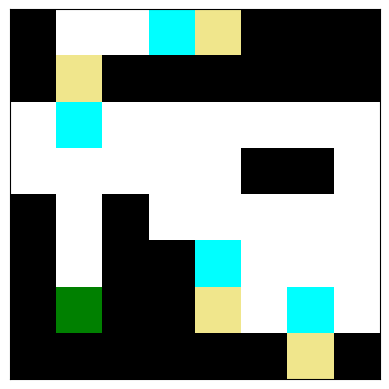

In [26]:
viz.plot_mini_sokoban(state_clean["real_states"][0])

In [10]:
state_corrupt["real_states"][0][:,2,3]

tensor([0, 0, 0, 0, 0, 0, 1], dtype=torch.uint8)

In [29]:
def run_patched_drcnet(patch_activs):
    mode = "cell"
    inter_ticks = [1]
    patch_dict = {2: list(range(32))}
    patch_net = ActPatchDRCNet(drc_net)
    patch_action, patch_action_probs, patch_logits, patch_rnn_state = patch_net.forward_patch(env_out, rnn_state, activ_type=mode, activ_ticks=inter_ticks,
                                                                        patch_dict=patch_dict, activs=patch_activs)
    return patch_rnn_state[-1][:,20,1,1]

In [12]:
from captum.attr import IntegratedGradients

In [30]:
intgrad = IntegratedGradients(run_patched_drcnet)
attr_results = intgrad.attribute(inputs=drc_net.hidden_state[:,1:,:,:,:].clone().detach(), baselines=patch_activs, n_steps=200)

In [31]:
attr_results.sum()

tensor(1.3723, dtype=torch.float64)

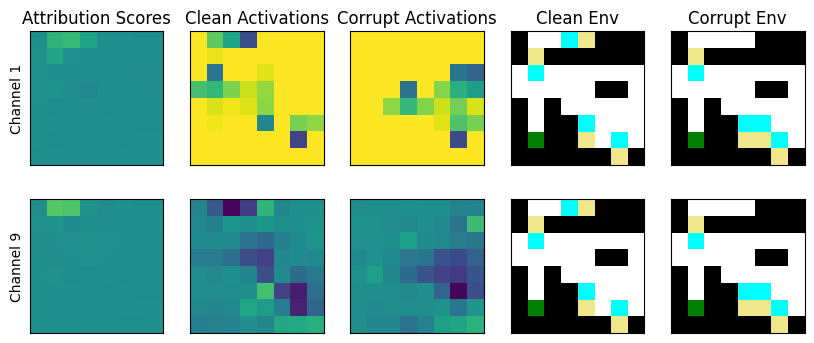

In [38]:
channels = [1,9]
fig, axs = plt.subplots(len(channels),5, figsize=(10,2*len(channels)))

state_c = state_clean["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board_c = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

state_co = state_corrupt["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_co.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_co[:,:,i-1] == 1)] = i
mini_board_co = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(attr_results[0,1,160+channels[i],:,:].detach(), vmin=-0.3, vmax=0.3)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,2,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(patch_activs[0,1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board_c, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    board_img = axs[i][4].imshow(mini_board_co, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

axs[0][0].set_title("Attribution Scores")
axs[0][1].set_title("Clean Activations")
axs[0][2].set_title("Corrupt Activations")
axs[0][3].set_title("Clean Env")
axs[0][4].set_title("Corrupt Env")
plt.show()

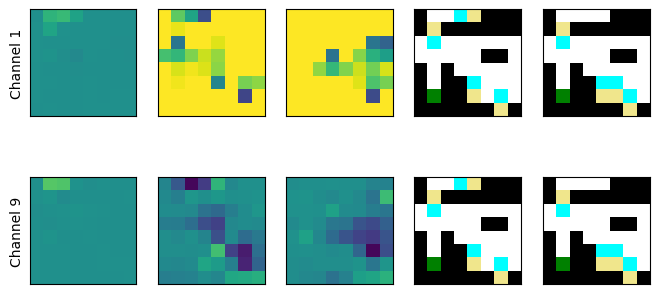

In [39]:
channels = [1,9]
fig, axs = plt.subplots(len(channels),5, figsize=(8,2*len(channels)))

state_c = state_clean["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board_c = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

state_co = state_corrupt["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_co.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_co[:,:,i-1] == 1)] = i
mini_board_co = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(attr_results[0,1,160+channels[i],:,:].detach(), vmin=-0.3, vmax=0.3)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,2,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(patch_activs[0,1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board_c, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    board_img = axs[i][4].imshow(mini_board_co, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
plt.show()

In [180]:
attr_results.sum()

tensor(0., dtype=torch.float64)